<a href="https://colab.research.google.com/github/thiagobcoelho25/churn-prediction-sigmoidal/blob/main/Thiago_Ribeiro_Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [2]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# remove limite para quantidade de colunas
pd.set_option('display.max_columns', None)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploração dos Dados

In [3]:
# tamanho do dataset
print(f'O dataset possui {df.shape[0]} linhas, com {df.shape[1]} colunas')

O dataset possui 7043 linhas, com 21 colunas


In [4]:
# tipos das colunas
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

A maioria das colunas são do tipo `object`, entretanto o atributo `TotalCharges`, sendo tambem do tipo `object`, possui valores numericos. Nesse caso devemos trata-lo como um float. Para isso iremos utilizar o metodo `to_numeric` da biblioteca ***pandas***, onde os valores que não puderem ser transformados para numericos irão ser considerados como **NaN**. Tambem iremos tratar esse mesmos valores nulos para 0.

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [6]:
# valores nulos
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [7]:
df['TotalCharges'].fillna(0, inplace=True)

In [8]:
# resumo statístico das dos atributos
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Inicialmente não encontramos outliers entre os valores numericos, com exeção da coluna `SeniorCitizen`, que possui apenas 2 valores possiveis, não representando uma atributo a ser tratado.

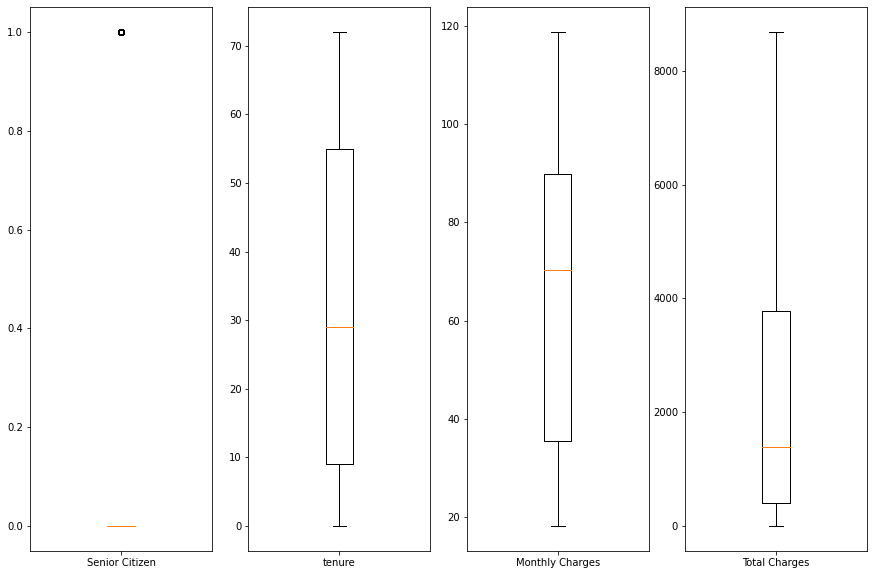

In [9]:
# outliers para os atributos numericos
fig, (ax_boxplot_SeniorCitizen, ax_boxplot_tenure, ax_boxplot_MonthlyCharges, ax_boxplot_TotalCharges) = plt.subplots(1, 4, figsize=(15,10))
ax_boxplot_SeniorCitizen.boxplot(x=df['SeniorCitizen'], labels=['Senior Citizen']);
ax_boxplot_tenure.boxplot(x=df['tenure'], labels=['tenure']);
ax_boxplot_MonthlyCharges.boxplot(x=df['MonthlyCharges'], labels=['Monthly Charges']);
ax_boxplot_TotalCharges.boxplot(x=df['TotalCharges'], labels=['Total Charges']);

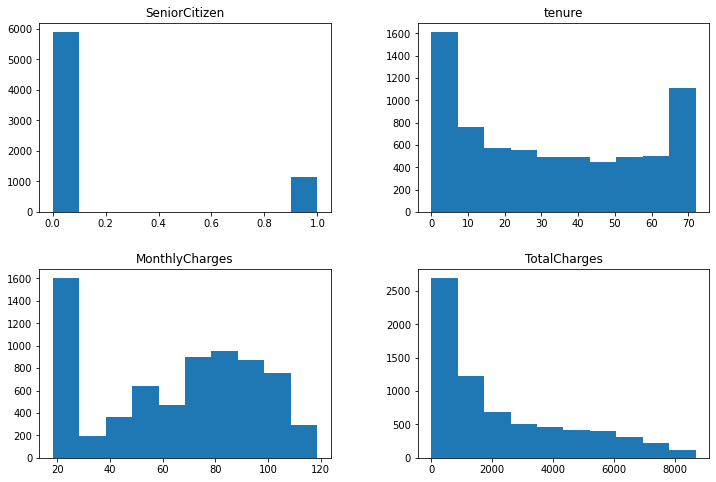

In [10]:
# distribuição dos atributos numericos
df.hist(figsize=(12,8), grid=False);

No exemplo seguinte, plotamos os graficos de barra para os atributo categóricos, onde podemos ver suas distribuições e possiveis valores encontrados em suas respectivas colunas.

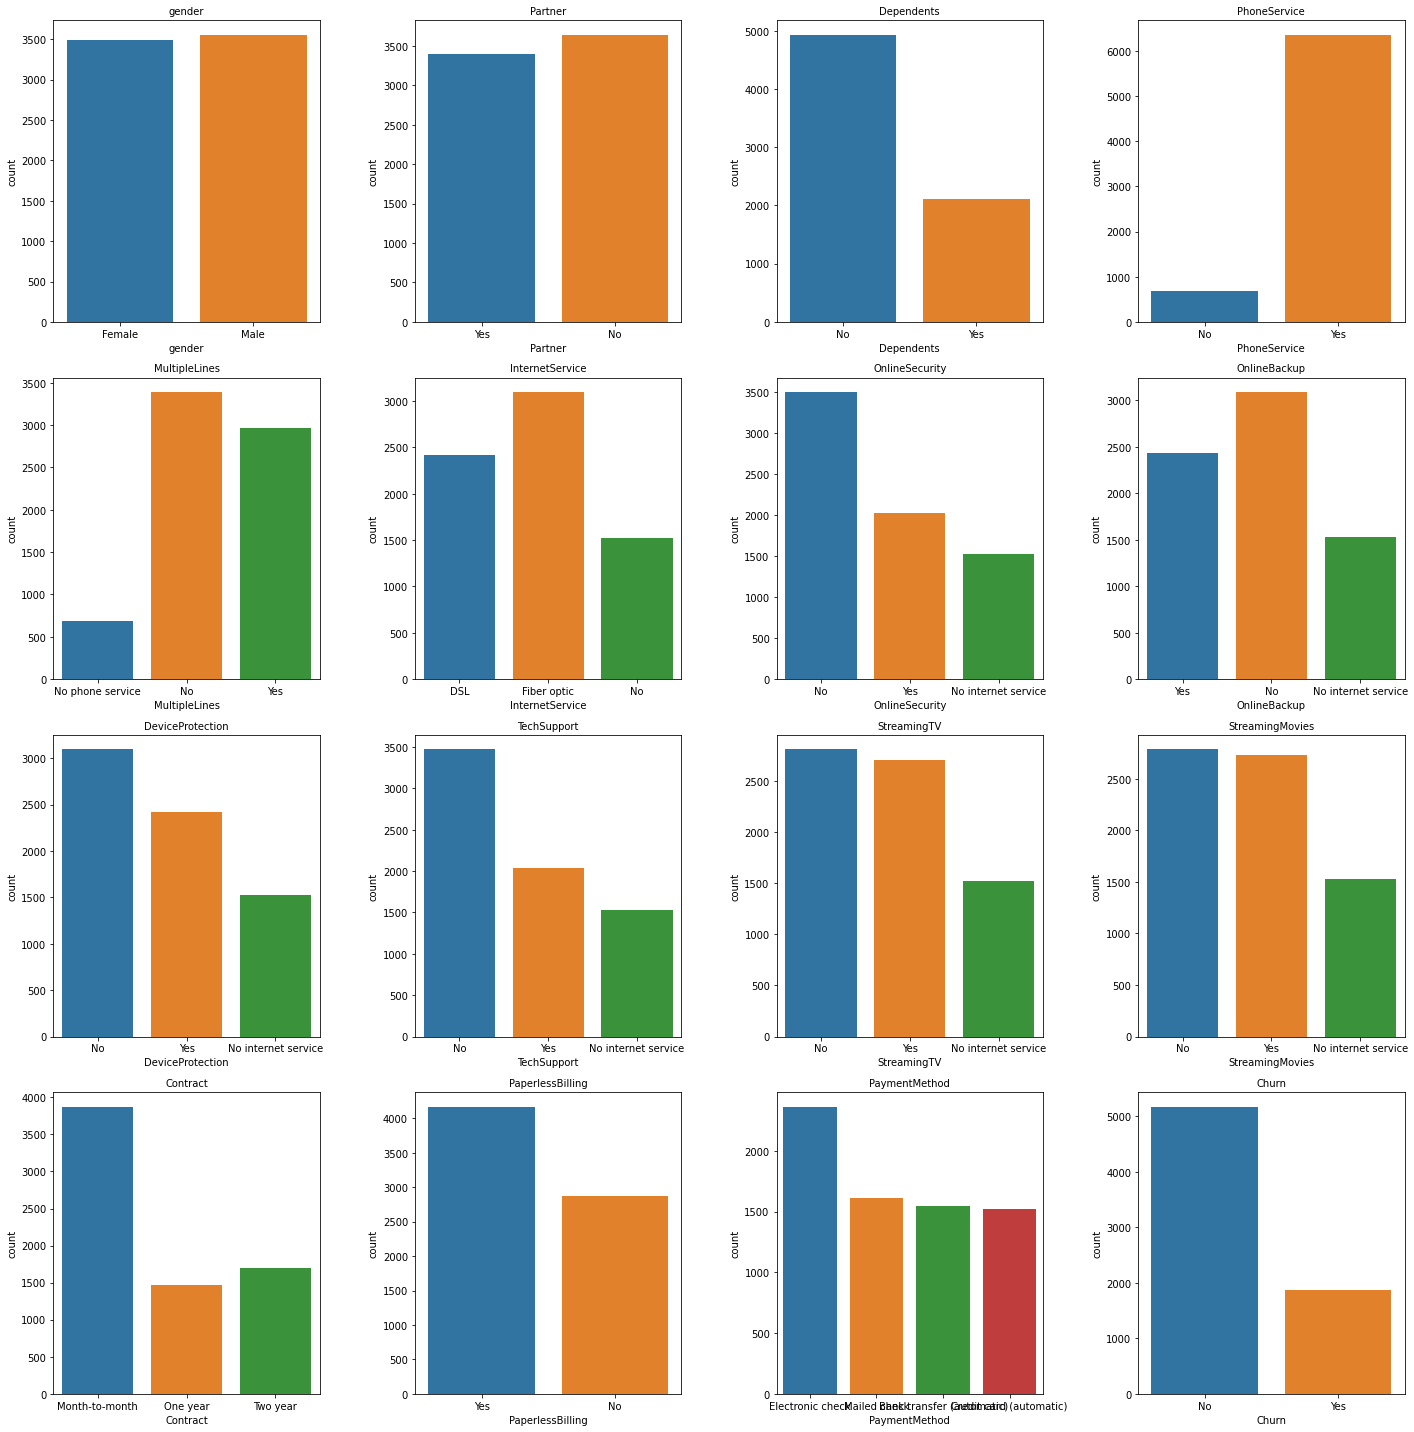

In [11]:
column_names = df.drop(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'customerID', 'TotalCharges'], axis=1).columns
num_plots = len(column_names)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(4, 4, idx)
    sns.countplot(x=col, data=df)
    plt.title(col, fontsize=10)
plt.tight_layout()

Inicialmente podemos ver que o dataset possui um desbalanceamento em relação a classe alvo `Churn`, em uma proporção maior para os valores iguais a `No`. Durante o processo de *split* faremos o balanceamento para o dataset de treino.

In [12]:
# procentagem da classe 'Churn'
(df['Churn'].value_counts() / df.shape[0])*100

No     73.463013
Yes    26.536987
Name: Churn, dtype: float64

### No internet service or phone service?

Analisando a distribuição de algumas colunas, percebi que, entre elas, existem uma relação na quantidade de algumas categorias caso não tenha servico de telefone (`PhoneService`) ou que não tenha servico de internet (`InternetService`).

Vamos pegar por exemplo o atributo `InternetService`.

In [13]:
# quantidade de entradas no dataset para clientes que não possuem servico de internet
df_no_internet_service = df[df['InternetService'] == 'No']
df_no_internet_service.shape[0]

1526

In [14]:
df_no_internet_service.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
11,7469-LKBCI,Male,0,No,No,16,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),18.95,326.80,No
16,8191-XWSZG,Female,0,No,No,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,1022.95,No
21,1680-VDCWW,Male,0,Yes,No,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),19.80,202.25,No
22,1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes
33,7310-EGVHZ,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.20,20.20,No


Percebemos, que em todas as entradas onde a coluna `InternetService` e igual a `'No'`, respectivamente os atributos com relação a serviços de internet tambem teram categorias do tipo `'No internet service'` na mesma proporção.

In [15]:
df_no_internet_service[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].value_counts()

OnlineSecurity       OnlineBackup         DeviceProtection     TechSupport          StreamingTV          StreamingMovies    
No internet service  No internet service  No internet service  No internet service  No internet service  No internet service    1526
dtype: int64

Para validar essa teoria, fazemos uma analise em outra coluna com relação a servico de internet, para verificar se possuem a mesma quantidade de entradas da coluna `InternetService` quando o valor do atributo e igual a `'No'`.

In [16]:
# quantidade de entradas quando a coluna 'TechSupport' possue valor 'No internet service'
df[df['TechSupport'] == 'No internet service'].shape[0]

1526

Essa mesma relação/teoria aparece para a coluna `MultipleLines`. Quando seu valor e igual a `'No phone service'`, a mesma proporção aparece para a coluna `PhoneService` com valores `'No'`.

In [17]:
df_no_mutiline = df[df['MultipleLines'] == 'No phone service']
df_no_mutiline.shape[0]

682

In [18]:
df_no_mutiline['PhoneService'].value_counts()

No    682
Name: PhoneService, dtype: int64

Com essa teoria proposta, podemos, aparentemente, subtrair alguns valores para algumas colunas, assim quando aplicarmos o `LabelEncoder()` e/ou `HotOneEncoder()` teremos menos colunas e valores em excesso.

Inicialmente não retirarei esses dados, seguindo com a tranformação dos mesmo normalmente.

## Preparação dos Dados

Para alguns algoritmos de ML, é nescessario a transformação de colunas do tipo categorico para tipos int/float. Nesse casos podemos usar as tecnicas de `LabelEncoder()` e/ou `HotOneEncoder()`.
* `LabelEncoder` Funciona convertendo cada valor em uma coluna em um número. podem impor uma relação ordinal onde não existe tal relação ex: 0 < 1 < 2. Isso pode causar problemas e uma codificação one-hot pode ser usada em seu lugar.
* `HotOneEncoder` Nesta estratégia, cada valor de categoria é convertido em uma nova coluna e atribuído um valor 1 ou 0 (notação para verdadeiro/falso) à coluna

Segundo esse post no forum **[datascience.stackexchange.com](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor)**,
* `HotOneEncoder` Quando os valores que estão próximos uns dos outros na codificação do rótulo correspondem a valores de destino que não estão próximos (dados não lineares) ou quando o traço categórico não é ordinal (cachorro, gato, rato).
* `LabelEncoder` O traço categórico é ordinal (Jr. kg, Sr. kg, Ensino Fundamental, Ensino Médio, etc) ou quando podemos criar um codificador de rótulos que atribui rótulos próximos a categorias semelhantes: Isso leva a menos divisões nas árvores, reduzindo o tempo de execução.

Em todo caso iremos criar dois **dataframes**, um para a utilização de `LabelEncoder` junto com `OneHotEncoder` e outro apenas com `OneHotEncoder`. 

### LabelEncoder + HotEncoder

In [19]:
# copia do dataframe para LabelEncoder + OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

df_copy_label_hot = df.copy()

In [20]:
all_columns_hot_encoder = OneHotEncoder(sparse=False, dtype=int)

In [21]:
all_columns_hot_encoded = all_columns_hot_encoder.fit_transform(df_copy_label_hot[['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                                                                'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                                                                'StreamingTV', 'StreamingMovies', 'PaymentMethod']])

In [22]:
all_columns_hot_encoder.get_feature_names_out()

array(['gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automa

In [23]:
df_copy_label_hot.drop(columns=['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                              'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                              'StreamingTV', 'MultipleLines', 'StreamingMovies', 'PaymentMethod'], inplace=True)

df_copy_label_hot[['gender_female', 'gender_male','partner_no', 'partner_yes',
       'dependents_no', 'dependents_yes', 'phone_service_no',
       'phone_service_yes', 'paperless_billing_no', 'paperless_billing_yes',
        'multiple_lines_no', 'multiple_lines_no_phone_service',
       'multiple_lines_yes','internet_service_dsl',
       'internet_service_fiber_optic', 'internet_service_no',
       'online_security_no', 'online_security_no_internet_service',
       'online_security_yes', 'online_backup_no',
       'online_backup_no_internet_service', 'online_backup_yes',
       'device_protection_no', 'device_protection_no_internet_service',
       'device_protection_yes', 'tech_support_no',
       'tech_support_no_internet_service', 'tech_support_yes',
       'streaming_tv_no', 'streaming_tv_no_internet_service',
       'streaming_tv_yes', 'streaming_movies_no',
       'streaming_movies_no_internet_service', 'streaming_movies_yes',
       'bank_transfer',
       'credit_card',
       'electronic_check', 'mailed_check']] = all_columns_hot_encoded

In [24]:
# Churn
label_encoder_churn = LabelEncoder()
df_copy_label_hot['Churn'] = label_encoder_churn.fit_transform(df_copy_label_hot['Churn'])

In [25]:
# copia do dataframe para LabelEncoder + OneHotEncoder
df_copy_full_hot = df_copy_label_hot.copy()

In [26]:
# Contract
label_encoder_contract = LabelEncoder()
#print(df['Contract'].unique())
label_encoder_contract.fit(['Month-to-month','One year','Two year'])
df_copy_label_hot['Contract'] = label_encoder_contract.transform(df_copy_label_hot['Contract'])

In [27]:
df_copy_label_hot.head()

,customerID,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,Churn,gender_female,gender_male,partner_no,partner_yes,dependents_no,dependents_yes,phone_service_no,phone_service_yes,paperless_billing_no,paperless_billing_yes,multiple_lines_no,multiple_lines_no_phone_service,multiple_lines_yes,internet_service_dsl,internet_service_fiber_optic,internet_service_no,online_security_no,online_security_no_internet_service,online_security_yes,online_backup_no,online_backup_no_internet_service,online_backup_yes,device_protection_no,device_protection_no_internet_service,device_protection_yes,tech_support_no,tech_support_no_internet_service,tech_support_yes,streaming_tv_no,streaming_tv_no_internet_service,streaming_tv_yes,streaming_movies_no,streaming_movies_no_internet_service,streaming_movies_yes,bank_transfer,credit_card,electronic_check,mailed_check
0,7590-VHVEG,0,1,0,29.85,29.85,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,0,34,1,56.95,1889.50,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1
2,3668-QPYBK,0,2,0,53.85,108.15,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,0,45,1,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0
4,9237-HQITU,0,2,0,70.70,151.65,1,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


### Full HotEncoder

In [28]:
contract_hot_encoder = OneHotEncoder(sparse=False, dtype=int)

In [29]:
contract_hot_encoded = contract_hot_encoder.fit_transform(df_copy_full_hot[['Contract']])

In [30]:
contract_hot_encoder.get_feature_names_out()

array(['Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year'], dtype=object)

In [31]:
df_copy_full_hot.drop(columns=['Contract'], inplace=True)

df_copy_full_hot[['contract_month-to-month', 'contract_one_year',
       'contract_two_year']] = contract_hot_encoded

In [32]:
df_copy_full_hot.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_female,gender_male,partner_no,partner_yes,dependents_no,dependents_yes,phone_service_no,phone_service_yes,paperless_billing_no,paperless_billing_yes,multiple_lines_no,multiple_lines_no_phone_service,multiple_lines_yes,internet_service_dsl,internet_service_fiber_optic,internet_service_no,online_security_no,online_security_no_internet_service,online_security_yes,online_backup_no,online_backup_no_internet_service,online_backup_yes,device_protection_no,device_protection_no_internet_service,device_protection_yes,tech_support_no,tech_support_no_internet_service,tech_support_yes,streaming_tv_no,streaming_tv_no_internet_service,streaming_tv_yes,streaming_movies_no,streaming_movies_no_internet_service,streaming_movies_yes,bank_transfer,credit_card,electronic_check,mailed_check,contract_month-to-month,contract_one_year,contract_two_year
0,7590-VHVEG,0,1,29.85,29.85,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,0,34,56.95,1889.50,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,3668-QPYBK,0,2,53.85,108.15,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,0,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0
4,9237-HQITU,0,2,70.70,151.65,1,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0


## Split dos dados de treino e teste 

Como propopsto anteriormente, iremos criar dois datasets, um com todas as colunas categoricas com a transformação `OneHotEndoder` e a outra com a utilização do `LabelEncoder` para o atributo `Contract`.

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# removendo coluna id
df_copy_full_hot.drop(columns=['customerID'], inplace=True)
df_copy_label_hot.drop(columns=['customerID'], inplace=True)

In [35]:
y_full_hot = df_copy_full_hot['Churn']
X_full_hot = df_copy_full_hot.drop('Churn', axis=1)

y_label_hot = df_copy_label_hot['Churn']
X_label_hot = df_copy_label_hot.drop('Churn', axis=1)

In [36]:
X_train_full_hot, X_test_full_hot, y_train_full_hot, y_test_full_hot = train_test_split(X_full_hot, y_full_hot, test_size=0.3, random_state=0, stratify=y_full_hot)

X_train_label_hot, X_test_label_hot, y_train_label_hot, y_test_label_hot = train_test_split(X_label_hot, y_label_hot, test_size=0.3, random_state=0, stratify=y_label_hot)

## Pipeline

Um pipeline de aprendizado de máquina pode ser criado reunindo uma sequência de etapas envolvidas no treinamento de um modelo de aprendizado de máquina. Ele pode ser usado para automatizar um fluxo de trabalho de aprendizado de máquina. O pipeline pode envolver pré-processamento, seleção de recursos, classificação/regressão e pós-processamento.

* https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [37]:
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as pipeline_imblearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [38]:
numeric_features_pipeline = ["tenure", "MonthlyCharges", "TotalCharges"]

transformer_standard_pipeline = make_pipeline(StandardScaler())
transformer_normalizer_pipeline = make_pipeline(Normalizer())
transformer_quantile_pipeline = make_pipeline(QuantileTransformer())

preprocessor_standard = ColumnTransformer(transformers=[("numeric", transformer_standard_pipeline, numeric_features_pipeline)], remainder='passthrough')
preprocessor_normalizer = ColumnTransformer(transformers=[("numeric", transformer_normalizer_pipeline, numeric_features_pipeline)], remainder='passthrough')
preprocessor_quantile = ColumnTransformer(transformers=[("numeric", transformer_quantile_pipeline, numeric_features_pipeline)], remainder='passthrough')

pipeline_standard_smote = make_pipeline_imblearn(preprocessor_standard, SMOTE())
pipeline_normalizer_smote = make_pipeline_imblearn(preprocessor_normalizer, SMOTE())
pipeline_quantile_smote = make_pipeline_imblearn(preprocessor_quantile, SMOTE())

pipeline_standard_under = make_pipeline(preprocessor_standard, RandomUnderSampler())
pipeline_normalizer_under = make_pipeline(preprocessor_normalizer, RandomUnderSampler())
pipeline_quantile_under = make_pipeline(preprocessor_quantile, RandomUnderSampler())

#final_pipeline_standard_LogisticRegression = make_pipeline(preprocessor_standard, LogisticRegression())

Em nosso caso inicial usaremos **Pipelines**, para o dataset *full one hot encoded* e para o dataset de *label encoded + hot encoded*, com as configurações de padronização/normalização do tipo `StandardScaler`, `Normalizer` e `QuantileTransformer`. Tambem para cada uma deles usaremos dois tipos de balanceamnetos: `SMOTE` e `RandomUnderSampler`.

In [39]:
# visualização da pipeline
#set_config(display="diagram")
#pipeline_standard_under

## CONSTRUÇÃO DE MODELO(S) DE MACHINE LEARNING

Inicialmente usaremos a tecnica de validação cruzada (**cross-validation**) nos conjuntos de treino a fim de encontrar os melhores algoritmos.

A validação cruzada é uma técnica para avaliar como a análise estatística se generaliza para um conjunto de dados independente. É uma técnica para avaliar modelos de aprendizado de máquina treinando vários modelos em subconjuntos dos dados de entrada disponíveis e avaliando-os no subconjunto complementar dos dados. Usando validação cruzada, há grandes chances de que possamos detectar o ajuste excessivo com facilidade.

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
models = [LogisticRegression(), SGDClassifier(), XGBClassifier()]
balances = [SMOTE(), RandomUnderSampler()]
normalizations = [preprocessor_standard, preprocessor_normalizer, preprocessor_quantile]

dic = {'Tipo': [], 'Modelo': [], 'Balanceamento':[], 'Dimensionamento': [], 'Recall': []}

In [ ]:
preprocessor_standard._transformers[0][1].steps[0][0]

'standardscaler'

In [ ]:
pipeline_standard_under.steps[1][0]

'randomundersampler'

In [ ]:
# cross-validation
for tipo in ( ('Full_Hot', (X_train_full_hot, y_train_full_hot)), ('Label_Hot',(X_train_label_hot, y_train_label_hot)) ):
  for model in models:
    for balance in balances:
      for norm in normalizations:
        dic['Tipo'].append(tipo[0])
        dic['Modelo'].append(model)
        dic['Balanceamento'].append(balance)
        dic['Dimensionamento'].append(norm._transformers[0][1].steps[0][0])
        
        final_pipeline = pipeline_imblearn([('balance', balance), ('normalizations', norm), ('modelo', model)])
        resultado = cross_val_score(final_pipeline, tipo[1][0], tipo[1][1], cv=StratifiedKFold(), scoring='recall')
        dic['Recall'].append(resultado.mean().round(4))

In [ ]:
dataframe_dic = pd.DataFrame(data=dic)

Utilizaremos a metrica de `recall`, normalmente usada em situações em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos. Essa metrica irá nos mostrar a razão entre a quantidade de clientes que o modelo previu o cancelamento, e a quantidade de clientes que realmente cancelaram o serviço. Ou seja, mostra a proporção de positivos encontrados corretamente.

In [ ]:
dataframe_dic.sort_values(by='Recall', ascending=False).head(6)

,Tipo,Modelo,Balanceamento,Dimensionamento,Recall
27,Label_Hot,SGDClassifier(),RandomUnderSampler(),standardscaler,0.8204
22,Label_Hot,LogisticRegression(),RandomUnderSampler(),normalizer,0.8158
4,Full_Hot,LogisticRegression(),RandomUnderSampler(),normalizer,0.8112
28,Label_Hot,SGDClassifier(),RandomUnderSampler(),normalizer,0.8073
21,Label_Hot,LogisticRegression(),RandomUnderSampler(),standardscaler,0.8036
15,Full_Hot,XGBClassifier(),RandomUnderSampler(),standardscaler,0.8005


Dos 3 algortimos utilizados com as as tecnicas de padronização/normalização e transformações categoricas, temos:
* **SGDClassifier** com balanceamento **RandomUnderSampler** e dimensionamento **standardscaler** com media de 0.8204, utiliando os dado de *label + hot encoded*.
* **LogisticRegression** com balanceamento **RandomUnderSampler** e dimensionamento **normalizer** com media de 0.8158, utiliando os dado de *label + hot encoded*.
* **XGBClassifier** com balanceamento **RandomUnderSampler** e dimensionamento **standardscaler** com media de 0.8005, utiliando os dado de *full hot encoded*.

## Otimização de Hiperparâmetros

Para encontrarmos os melhores hiperparâmetros de cada algoritmo, utilizaremos a tecnica **Grid Search**. Essa técnica consiste em testar diferentes combinações de hiperparametros exaustivamente e separar a melhor.

Com o *sklearn* temos o metodo ***GridSearchCV*** que fundem as tecnicas de **Grid Search** juntamente com **cross-validation**.

### LogisticRegression

In [ ]:
parameters = [{
    'logisticregression__C': [0.001, 00.5, 0.1, 0.5, 1, 5],
    'logisticregression__solver': ['newton-cg','lbfgs', 'liblinear', 'saga'],
    'logisticregression__penalty': ['l2'],
    'logisticregression__max_iter': [100, 200, 500, 1000, 5000],
    'logisticregression__random_state': [0]
    },
    {
     'logisticregression__C': [0.001, 00.5, 0.1, 0.5, 1, 5],
     'logisticregression__solver': ['liblinear', 'saga'],
     'logisticregression__penalty': ['l1'],
     'logisticregression__max_iter': [100, 200, 500, 1000, 5000],
     'logisticregression__random_state': [0] 
    }]

In [ ]:
final_pipeline = pipeline_imblearn([('balance', RandomUnderSampler()), ('normalizations', preprocessor_normalizer), ('logisticregression', LogisticRegression())])

gs_cv = GridSearchCV(final_pipeline,
                     param_grid=parameters,
                     n_jobs=2,
                     scoring='recall',
                     cv=StratifiedKFold()).fit(X_train_label_hot, y_train_label_hot)

print("Melhor: {} usando {}".format(gs_cv.best_score_, gs_cv.best_params_))

Melhor: 0.8333772045275072 usando {'logisticregression__C': 0.001, 'logisticregression__max_iter': 500, 'logisticregression__penalty': 'l2', 'logisticregression__random_state': 0, 'logisticregression__solver': 'liblinear'}


### SGDClassifier

In [ ]:
parameters = {
    'sgdclassifier__alpha': [0.0001, 0.0005, 0.001, 0.05, 0.1],
    'sgdclassifier__loss': ['perceptron','hinge', 'log', 'squared_error'],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__random_state': [0],
    'sgdclassifier__max_iter': [100,500,1000,5000,10000]
    }

In [ ]:
final_pipeline = pipeline_imblearn([('balance', RandomUnderSampler()), ('normalizations', preprocessor_standard), ('sgdclassifier', SGDClassifier())])

gs_cv = GridSearchCV(final_pipeline,
                     param_grid=parameters,
                     n_jobs=2,
                     scoring='recall',
                     cv=StratifiedKFold()).fit(X_train_label_hot, y_train_label_hot)

print("Melhor: {} usando {}".format(gs_cv.best_score_, gs_cv.best_params_))

Melhor: 0.906010353601825 usando {'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__max_iter': 500, 'sgdclassifier__penalty': 'l1', 'sgdclassifier__random_state': 0}


### XGBClassifier

In [ ]:
final_pipeline = pipeline_imblearn([('balance', RandomUnderSampler()), ('normalizations', preprocessor_standard), ('xgbclassifier', XGBClassifier())])

parameters = {
    'xgbclassifier__learning_rate': [0.001, 0.05, 0.01, 0.1, 0.3],
    'xgbclassifier__n_estimators': [10,20,50,100,200],
    'xgbclassifier__max_depth': [2,3,5],
    'xgbclassifier__gamma': [0.0, 0.001, 0.1, 0.2],
    'xgbclassifier__random_state': [0],
    'xgbclassifier__booster': ['gbtree', 'gblinear', 'dart']
}

gs_cv = GridSearchCV(final_pipeline,
                     param_grid=parameters,
                     n_jobs=-1,
                     scoring='recall',
                     cv=StratifiedKFold()).fit(X_train_full_hot, y_train_full_hot)

print("Melhor: {} usando {}".format(gs_cv.best_score_, gs_cv.best_params_))

Melhor: 0.873130355941622 usando {'xgbclassifier__booster': 'gblinear', 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.001, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 20, 'xgbclassifier__random_state': 0}


Com a tecnica de **Grid Search** conseguimos os seguintes hiperparametros de cada algoritmo:
* LogisticRegression com valor de recall de 0.8333772045275072 usando **C: 0.001**, **max_iter: 500**, **penalty: l2**, **random_state: 0** e **solver: liblinear**.
* SGDClassifier com valor de recall de 0.906010353601825 usando **alpha: 0.1**, **loss: hinge**, **max_iter: 500**, **penalty: l1**, **random_state: 0**.
* XGBClassifier com valor de recall de 0.873130355941622 usando **booster: gblinear**, **gamma: 0.1**, **learning_rate: 0.001**, **max_depth: 5**, **n_estimators: 20**, **random_state: 0**.

## Validação dos Hiperparâmetros

In [41]:
X_train_label_hot_final = X_train_label_hot.copy()
y_train_label_hot_final = y_train_label_hot.copy()

X_train_full_hot_final = X_train_full_hot.copy()
y_train_full_hot_final = y_train_full_hot.copy()

X_test_label_hot_final = X_test_label_hot.copy()
X_test_full_hot_final = X_test_full_hot.copy()

### LogisticRegression

In [ ]:
randomundersampler = RandomUnderSampler()

In [ ]:
X_train_label_hot_final, y_train_label_hot_final = randomundersampler.fit_resample(X_train_label_hot_final, y_train_label_hot_final)

In [ ]:
normalizer = Normalizer()
X_train_label_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]] = normalizer.fit_transform(X_train_label_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]])
X_test_label_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]] = normalizer.fit_transform(X_test_label_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]])

In [ ]:
logisticregression = LogisticRegression(C=0.001, max_iter=500, penalty='l2', solver='liblinear', random_state=0)

In [ ]:
logisticregression.fit(X_train_label_hot_final, y_train_label_hot_final)

LogisticRegression(C=0.001, max_iter=500, random_state=0, solver='liblinear')

In [ ]:
resultados = logisticregression.predict(X_test_label_hot_final)

In [ ]:
print(classification_report(y_test_label_hot, resultados))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1552
           1       0.48      0.84      0.62       561

    accuracy                           0.72      2113
   macro avg       0.70      0.76      0.70      2113
weighted avg       0.81      0.72      0.74      2113



### SGDClassifier

In [ ]:
randomundersampler = RandomUnderSampler()

In [ ]:
X_train_label_hot_final, y_train_label_hot_final = randomundersampler.fit_resample(X_train_label_hot_final, y_train_label_hot_final)

In [ ]:
standardscaler = StandardScaler()
X_train_label_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]] = normalizer.fit_transform(X_train_label_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]])
X_test_label_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]] = normalizer.fit_transform(X_test_label_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]])

In [ ]:
sgdclassifier = SGDClassifier(alpha=0.1, loss='hinge', max_iter=500, penalty='l1', random_state=0)

In [ ]:
sgdclassifier.fit(X_train_label_hot_final, y_train_label_hot_final)

SGDClassifier(alpha=0.1, max_iter=500, penalty='l1', random_state=0)

In [ ]:
resultados = sgdclassifier.predict(X_test_label_hot_final)

In [ ]:
print(classification_report(y_test_label_hot, resultados))

              precision    recall  f1-score   support

           0       0.93      0.58      0.72      1552
           1       0.43      0.87      0.58       561

    accuracy                           0.66      2113
   macro avg       0.68      0.73      0.65      2113
weighted avg       0.80      0.66      0.68      2113



### XGBClassifier

In [45]:
randomundersampler = RandomUnderSampler()

In [49]:
X_train_full_hot_final, y_train_full_hot_final = randomundersampler.fit_resample(X_train_full_hot_final, y_train_full_hot_final)

In [50]:
standardscaler = StandardScaler()
X_train_full_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]] = standardscaler.fit_transform(X_train_full_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]])
X_test_full_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]] = standardscaler.fit_transform(X_test_full_hot_final[["tenure", "MonthlyCharges", "TotalCharges"]])

In [51]:
xgbclassifier = XGBClassifier(gamma=0.1, learning_rate=0.001, n_estimators=20, random_state=0, max_depth=5, booster='gblinear')

In [52]:
xgbclassifier.fit(X_train_full_hot_final, y_train_full_hot_final)

XGBClassifier(booster='gblinear', gamma=0.1, learning_rate=0.001, max_depth=5,
              n_estimators=20)

In [53]:
resultados = xgbclassifier.predict(X_test_full_hot_final)

In [54]:
print(classification_report(y_test_full_hot, resultados))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1552
           1       0.43      0.90      0.58       561

    accuracy                           0.66      2113
   macro avg       0.69      0.74      0.65      2113
weighted avg       0.81      0.66      0.68      2113



## Resultado Parcial

In [46]:
!pip install -q scikit-plot

In [47]:
import scikitplot as skplt 

AUC: 0.7357



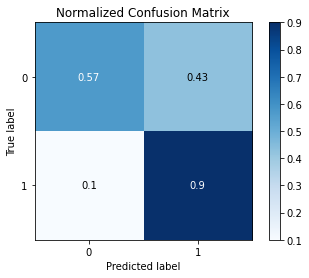

In [55]:
skplt.metrics.plot_confusion_matrix(y_test_full_hot, resultados, normalize=True)

# AUC
print("AUC: {:.4f}".format(roc_auc_score(y_test_full_hot, resultados)))
print('')

## Extra

Como observado no inicio, temos algumas colunas que são consideradas "redundantes" no dataset, por isso iremos aplicar so mesmos hiperparametros do melhor algoritmo encontrado no resuldato parcial com esse dataset resumido que criaremos.

In [56]:
import seaborn as sns

In [57]:
X_train_extra_label_hot = X_train_label_hot.copy()
y_train_extra_label_hot = y_train_label_hot.copy()

X_train_extra_full_hot = X_train_full_hot.copy()
y_train_extra_full_hot = y_train_full_hot.copy()

X_test_extra_label_hot = X_test_label_hot.copy()
X_test_extra_full_hot = X_test_full_hot.copy()

### Removendo Valores Redundantes

In [58]:
# Excluindo variáveis redundantes
colunas_redundantes = ['multiple_lines_no_phone_service','online_security_no_internet_service','online_backup_no_internet_service','device_protection_no_internet_service',
'tech_support_no_internet_service','streaming_tv_no_internet_service','streaming_movies_no_internet_service']

X_train_extra_label_hot.drop(colunas_redundantes, axis=1, inplace=True)
X_train_extra_full_hot.drop(colunas_redundantes, axis=1, inplace=True)

X_test_extra_label_hot.drop(colunas_redundantes, axis=1, inplace=True)
X_test_extra_full_hot.drop(colunas_redundantes, axis=1, inplace=True)

A coluna `TotalCharges` representa a mutiplicação das colunas `ternure` e `MonthlyCharges`, assim participando mais de uma vez no processo de ajuste de parâmetros do modelo. A fim de evitar isso iremos excluí-la.

In [59]:
# remove MonthlyCharges
X_train_extra_label_hot.drop(columns='TotalCharges', inplace=True)
X_train_extra_full_hot.drop(columns='TotalCharges', inplace=True)

X_test_extra_label_hot.drop(columns='TotalCharges', inplace=True)
X_test_extra_full_hot.drop(columns='TotalCharges', inplace=True)

### Validação dos Hiperparâmetros

In [60]:
X_train_extra_label_hot_final = X_train_extra_label_hot.copy()
y_train_extra_label_hot_final = y_train_extra_label_hot.copy()

X_train_extra_full_hot_final = X_train_extra_full_hot.copy()
y_train_extra_full_hot_final = y_train_extra_full_hot.copy()

X_test_extra_label_hot_final = X_test_extra_label_hot.copy()
X_test_extra_full_hot_final = X_test_extra_full_hot.copy()

#### XGBClassifier

In [61]:
randomundersampler = RandomUnderSampler()

In [62]:
X_train_extra_label_hot_final, y_train_extra_label_hot_final = randomundersampler.fit_resample(X_train_extra_label_hot_final, y_train_extra_label_hot_final)

In [63]:
standardscaler = StandardScaler()
X_train_extra_label_hot_final[["tenure", "MonthlyCharges"]] = standardscaler.fit_transform(X_train_extra_label_hot_final[["tenure", "MonthlyCharges"]])
X_test_extra_label_hot_final[["tenure", "MonthlyCharges"]] = standardscaler.fit_transform(X_test_extra_label_hot_final[["tenure", "MonthlyCharges"]])

In [64]:
xgbclassifier = XGBClassifier(gamma=0.1, learning_rate=0.001, n_estimators=20, random_state=0, max_depth=5, booster='gblinear')

In [65]:
xgbclassifier.fit(X_train_extra_label_hot_final, y_train_extra_label_hot_final)

XGBClassifier(booster='gblinear', gamma=0.1, learning_rate=0.001, max_depth=5,
              n_estimators=20)

In [66]:
resultados = xgbclassifier.predict(X_test_extra_label_hot_final)

In [67]:
print(classification_report(y_test_label_hot, resultados))

              precision    recall  f1-score   support

           0       0.95      0.56      0.71      1552
           1       0.43      0.91      0.58       561

    accuracy                           0.66      2113
   macro avg       0.69      0.74      0.64      2113
weighted avg       0.81      0.66      0.67      2113



AUC: 0.7370



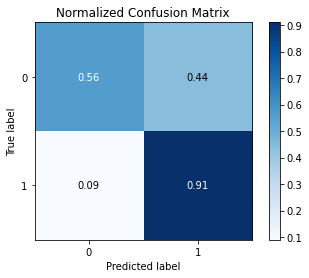

In [68]:
skplt.metrics.plot_confusion_matrix(y_test_full_hot, resultados, normalize=True)

# AUC
print("AUC: {:.4f}".format(roc_auc_score(y_test_full_hot, resultados)))
print('')

## Conclusão

O resultado parcial, com a transformação dos dados e sua normalização, apresentou no melhor algoritmo do treinamento, o `SGDClassifier`, um **Recall** de aproximadamente **90,6%**. Entretanto nos teste apresentou um resultado de aproximadamente **87%**, tendo o `XGBClassifier` se saido melhor com aproximadamente **90%**.

Alem disso, em um experimento extra, fizemos a remoção das colunas redundantes no dataset, apos a aplicação dos `OneHotEndode` e `LabelEncode`. Com essa nova base de dados utilizamos o melhor algoritmo nos teste, o `XGBClassifier`, com os mesmos hiperparametros e obtevemos uma leve melhora nos resultados de acuracia e *Recall*. 